# Model files and layouts
- Ref: https://huggingface.co/docs/diffusers/v0.34.0/en/using-diffusers/other-formats

In [1]:
#@title
import torch
cpu_use = False
if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
    cpu_use = True
print(t_device)

Current memory allocated on MPS: 0 bytes
Driver memory allocated on MPS: 393216 bytes
mps


## 1. Files


### 1.1. safetensors

In [2]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    use_safetensors=True
)

/Users/hyunjae.k/anaconda3/envs/2025_drills/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_single_file(
    "https://huggingface.co/WarriorMama777/OrangeMixs/blob/main/Models/AbyssOrangeMix/AbyssOrangeMix.safetensors"
)

Models/AbyssOrangeMix/AbyssOrangeMix.saf(…):   0%|          | 0.00/5.98G [00:00<?, ?B/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In this conversion only the non-EMA weights are extracted. If you want to instead extract the EMA weights (usually better for inference), please make sure to add the `--extract_ema` flag.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


#### 1.1.1 LoRA files

In [8]:
from pathlib import Path
import os

Path("./temp").mkdir(exist_ok=True, parents=True)

# download LoRA weights
if not os.path.exists("./temp/blueprintify.safetensors"):
    ! wget https://civitai.com/api/download/models/168776 -O ./temp/blueprintify.safetensors
else:
    print("already downloaded")

already downloaded


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

the original image size (1024, 1024)


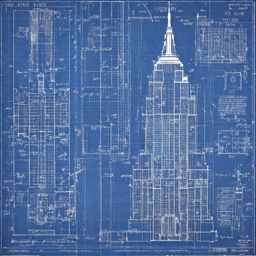

In [10]:
from diffusers import StableDiffusionXLPipeline
import torch

# base model
pipeline = StableDiffusionXLPipeline.from_pretrained(
    "Lykon/dreamshaper-xl-1-0", torch_dtype=torch.float16, variant="fp16"
).to(t_device)

# load LoRA weights
pipeline.load_lora_weights("./temp", weight_name="blueprintify.safetensors")
prompt = "bl3uprint, a highly detailed blueprint of the empire state building, explaining how to build all parts, many txt, blueprint grid backdrop"
negative_prompt = "lowres, cropped, worst quality, low quality, normal quality, artifacts, signature, watermark, username, blurry, more than one bridge, bad architecture"

image = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    generator=torch.manual_seed(0),
).images[0]
print(f"the original image size {image.size}")
image.resize((256, 256))

### 1.2 ckpt

In [ ]:
# from diffusers import StableDiffusionPipeline

# pipeline = StableDiffusionPipeline.from_single_file(
#     "https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5/blob/main/v1-5-pruned.ckpt"
# )

## Does not work

## 2. Layouts

### 2.1 Diffusers-multifolders


In [12]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
).to(t_device)

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.fp16.saf(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

the original image size (512, 512)


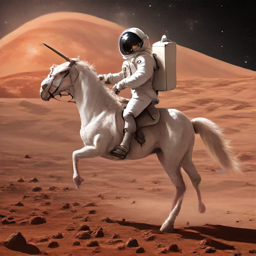

In [13]:
import torch
from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel, EulerDiscreteScheduler

# download one model
sdxl_pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
).to(t_device)

# switch UNet for another model
unet = UNet2DConditionModel.from_pretrained(
    "stabilityai/sdxl-turbo",
    subfolder="unet",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
# reuse all the same components in new model except for the UNet
turbo_pipeline = StableDiffusionXLPipeline.from_pipe(
    sdxl_pipeline, unet=unet,
).to(t_device)
turbo_pipeline.scheduler = EulerDiscreteScheduler.from_config(
    turbo_pipeline.scheduler.config,
    timestep_spacing="trailing"
)
image = turbo_pipeline(
    "an astronaut riding a unicorn on mars",
    num_inference_steps=1,
    guidance_scale=0.0,
).images[0]
print(f"the original image size {image.size}")
image.resize((256, 256))

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

the original image size (1024, 1024)


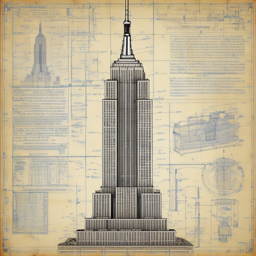

In [14]:
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, use_safetensors=True)
pipeline = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
).to(t_device)

prompt = "bl3uprint, a highly detailed blueprint of the empire state building, explaining how to build all parts, many txt, blueprint grid backdrop"
negative_prompt = "lowres, cropped, worst quality, low quality, normal quality, artifacts, signature, watermark, username, blurry, more than one bridge, bad architecture"

image = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    generator=torch.manual_seed(0),
).images[0]
print(f"the original image size {image.size}")
image.resize((256, 256))

### 2.2 Single file

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

the original image size (1024, 1024)


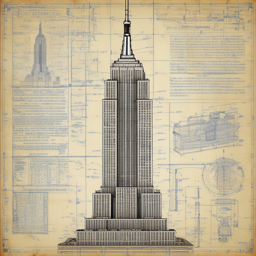

In [3]:
import torch
from diffusers import StableDiffusionXLPipeline

pipeline = StableDiffusionXLPipeline.from_single_file(
    "https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/sd_xl_base_1.0.safetensors",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
).to(t_device)

prompt = "bl3uprint, a highly detailed blueprint of the empire state building, explaining how to build all parts, many txt, blueprint grid backdrop"
negative_prompt = "lowres, cropped, worst quality, low quality, normal quality, artifacts, signature, watermark, username, blurry, more than one bridge, bad architecture"

image = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    generator=torch.manual_seed(0),
).images[0]
print(f"the original image size {image.size}")
image.resize((256, 256))

### 2.3 DDUF

In [4]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained(
    "DDUF/FLUX.1-dev-DDUF", dduf_file="FLUX.1-dev.dduf", torch_dtype=torch.bfloat16
).to(t_device)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

FLUX.1-dev.dduf:   0%|          | 0.00/33.7G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading state_dict: 100%|██████████| 2/2 [00:19<00:00,  9.85s/it]


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


  0%|          | 0/50 [00:00<?, ?it/s]

the original image size (1024, 1024)


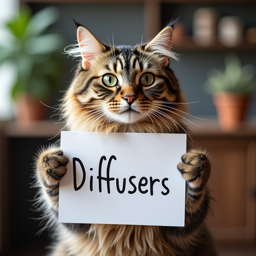

In [5]:
image = pipe(
    "photo a cat holding a sign that says Diffusers", num_inference_steps=50, guidance_scale=3.5
).images[0]
print(f"the original image size {image.size}")
image.resize((256, 256))

In [6]:
# from huggingface_hub import export_folder_as_dduf
# from diffusers import DiffusionPipeline
# import torch

# pipe = DiffusionPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16)

# save_folder = "./temp/flux-dev"
# pipe.save_pretrained("./temp/flux-dev")
# export_folder_as_dduf("./temp/flux-dev.dduf", folder_path=save_folder)



In [7]:
# from diffusers import StableDiffusionXLPipeline

# pipeline = StableDiffusionXLPipeline.from_single_file(
#     "https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/sd_xl_base_1.0.safetensors",
# )
# pipeline.save_pretrained()

# Does not work

## 3. Single-file layout usage

#### 3.1 Load a pipeline or model

In [8]:
from diffusers import StableDiffusionXLPipeline

ckpt_path = "https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/sd_xl_base_1.0_0.9vae.safetensors"
pipeline = StableDiffusionXLPipeline.from_single_file(ckpt_path)

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
from diffusers import StableCascadeUNet

ckpt_path = "https://huggingface.co/stabilityai/stable-cascade/blob/main/stage_b_lite.safetensors"
model = StableCascadeUNet.from_single_file(ckpt_path)

In [10]:
from diffusers import StableDiffusionXLPipeline, DDIMScheduler

ckpt_path = "https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/sd_xl_base_1.0_0.9vae.safetensors"
scheduler = DDIMScheduler()
pipeline = StableDiffusionXLPipeline.from_single_file(ckpt_path, scheduler=scheduler)

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

ckpt_path = "https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5/blob/main/v1-5-pruned-emaonly.safetensors"
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny")
pipeline = StableDiffusionControlNetPipeline.from_single_file(ckpt_path, controlnet=controlnet)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


#### 3.2 Customize configuration options

In [12]:
from diffusers import StableDiffusionXLPipeline

ckpt_path = "https://huggingface.co/segmind/SSD-1B/blob/main/SSD-1B.safetensors"
repo_id = "segmind/SSD-1B"

pipeline = StableDiffusionXLPipeline.from_single_file(ckpt_path, config=repo_id)

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [13]:
from diffusers import StableDiffusionXLPipeline

ckpt_path = "https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/sd_xl_base_1.0_0.9vae.safetensors"
original_config = "https://raw.githubusercontent.com/Stability-AI/generative-models/main/configs/inference/sd_xl_base.yaml"

pipeline = StableDiffusionXLPipeline.from_single_file(ckpt_path, original_config=original_config)

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [14]:
# from diffusers import StableDiffusionXLInstructPix2PixPipeline

# ckpt_path = "https://huggingface.co/stabilityai/cosxl/blob/main/cosxl_edit.safetensors"
# pipeline = StableDiffusionXLInstructPix2PixPipeline.from_single_file(ckpt_path, config="diffusers/sdxl-instructpix2pix-768", is_cosxl_edit=True)

# Web address is not available

In [15]:
from diffusers import UNet2DConditionModel

ckpt_path = "https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/sd_xl_base_1.0_0.9vae.safetensors"
model = UNet2DConditionModel.from_single_file(ckpt_path, upcast_attention=True)

#### 3.3 Local files

In [16]:
from huggingface_hub import hf_hub_download, snapshot_download

my_local_checkpoint_path = hf_hub_download(
    repo_id="segmind/SSD-1B",
    filename="SSD-1B.safetensors"
)

my_local_config_path = snapshot_download(
    repo_id="segmind/SSD-1B",
    allow_patterns=["*.json", "**/*.json", "*.txt", "**/*.txt"]
)

pipeline = StableDiffusionXLPipeline.from_single_file(my_local_checkpoint_path, config=my_local_config_path, local_files_only=True)

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
from huggingface_hub import hf_hub_download, snapshot_download

my_local_checkpoints = "./temp/my_local_checkpoints"
my_local_checkpoint_path = hf_hub_download(
    repo_id="segmind/SSD-1B",
    filename="SSD-1B.safetensors",
    local_dir=my_local_checkpoints,
    local_dir_use_symlinks=False
)
print("My local checkpoint: ", my_local_checkpoint_path)

my_local_config_path = snapshot_download(
    repo_id="segmind/SSD-1B",
    allow_patterns=["*.json", "**/*.json", "*.txt", "**/*.txt"],
    local_dir_use_symlinks=False,
)
print("My local config: ", my_local_config_path)

/Users/hyunjae.k/anaconda3/envs/2025_drills/lib/python3.10/site-packages/huggingface_hub/file_download.py:980: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


My local checkpoint:  temp/my_local_checkpoints/SSD-1B.safetensors


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

My local config:  /Users/hyunjae.k/.cache/huggingface/hub/models--segmind--SSD-1B/snapshots/60987f37e94cd59c36b1cba832b9f97b57395a10


In [18]:
pipeline = StableDiffusionXLPipeline.from_single_file(my_local_checkpoint_path, config=my_local_config_path, local_files_only=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]